# 1. Instalación e importación de bibliotecas

In [2]:
!git clone https://github.com/angelfergar/ChurnRetention-SP.git

Cloning into 'ChurnRetention-SP'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 110 (delta 47), reused 33 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (110/110), 4.19 MiB | 14.40 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.metrics import precision_recall_curve, auc
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from joblib import dump

In [4]:
dataset_path = '/content/ChurnRetention-SP/data/preprocessed_customerChurn.csv'
df = pd.read_csv(dataset_path)

# 2. Equilibrado de datos

Creamos los dataset que usaremos para el entrenamiento de los modelos

In [5]:
df_X = df.drop('Churn Label', axis=1)
df_y = df['Churn Label']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

Aumentamos de forma sintética la clase minoritaria un 65% y reduce la clase mayoritaria en un 25% (Se llega a estas cifras a base de prueba y error). De esta forma, pasamos de tener una proporción de 3:1 a una de 1.25 sin introducir un exceso de ruido que pueda provocar overfitting en el modelo ni perder una gran cantidad de datos.

In [7]:
smote = SMOTE(sampling_strategy=0.6)
under = RandomUnderSampler(sampling_strategy=0.8)

# Creamos un pipeline para aplicar ambas técnicas a la vez
pipeline = Pipeline([('smote', smote), ('under', under)])

# Obtenemos dos nuevos datasets con los datos equilibrados
X_train_smote, y_train_smote = pipeline.fit_resample(X_train, y_train)

print('Distribución de clases antes de Balanceo:', y_train.value_counts())
print('Distribución de clases después de Balanceo:', pd.Series(y_train_smote).value_counts())

Distribución de clases antes de Balanceo: Churn Label
0    3615
1    1315
Name: count, dtype: int64
Distribución de clases después de Balanceo: Churn Label
0    2711
1    2169
Name: count, dtype: int64


Este ajuste no supone una reducción excesiva ya que se han eliminado 904 muestras de la clase mayoritaria. De la misma forma, el haber añadido, de forma sintética, 854 muestras a la clase minoritaria no debería crear mucho ruido a la hora de desarrollar los modelos, por lo que no tendría que haber problemas de overfitting.

Este equilibrado se utilizará como punto de partida para optimizar los
diferentes modelos, pero se usarán una serie de valores adicionales a los elegidos cuando apliquemos las técnicas de validación cruzada y grid search sobre el modelo que mejores métricas haya obtenido.



# 3. Entrenamiento de los modelos

En este apartado vamos a trabajar con cinco modelos de machine learning: **Linear Regression, Decision Tree, Random Forest, XGBoost y LightGBM.** El objetivo es entrenar los modelos y analizar las métricas que son más relevantes en el caso tratado.

Al contar con un cierto desbalance en el dataset, métricas como Precision y Recall pueden no ser suficientes para evaluar el rendimiento de los modelos. Por una parte, la precisión podría verse afectada por el incremento de falsos positivos, dado que SMOTE ha generado casos sintéticos que podrían aumentar las predicciones de los clientes que se han dado de baja. Por otra parte, el Recall podría aumentar por el mayor énfasis dado a la clase minoritaria, pero esto no significa que se pueda garantizar que las predicciones sean consistentes o útiles en el contexto trabajado.

Debido a estas razones, **usaremos F1-Score como métrica principal** para determinar la eficacia de los modelos. Esto se debe a que combina Precision y Recall, penalizando modelos que tengan un desequilibrio entre ambas. Esto es particularmente importante tras haber aplicado las técnicas de equilibrado de datos, ya que el F1-Score permite verificar si el modelo realmente ha aprendido a identificar de manera efectiva los casos de clientes que se han dado de baja.

También **usaremos otras métricas como la ROC Curve y la Precision-Recall Curve**. Es cierto que la ROC Curve ya que el dataset tratado cuenta con un cierto rango de desbalanceo, y esta métrica tiende a obtener una mayoría de verdaderos negativos, lo que puede hacer que esta métrica se vea un poco inflada. Por ello, también analizaremos la Precisión-Recall Curve, ya que esta es mucho más óptima en contextos donde existan desequilibrios entre las clases, ya que refleja cual es el rendimiento de la clase minoritaria.



Crearemos una serie de funciones para poder reutilizar código y mostrar más fácilmente todo el reporte de cada uno de los modelos. El primer paso será entrenar el modelo y mostrar las features que más impactan a la hora de predecir el Churn

In [8]:
# Con esta función entrenamos el modelo, vemos la importancia de las features
def train_and_features(model_type, X_train, X_test, y_train, y_test):

  # Entrenamos el modelo y realizamos predicciones
  model_type.fit(X_train, y_train)
  y_pred = model_type.predict(X_test)

  # Mostramos las métricas del modelo
  print(f'Métricas: \n {classification_report(y_test, y_pred)}')

  # Obtenemos la importancia de las diferentes features
  feature_names = X_train.columns
  # Creamos este condicional ya que la Regresión Logística no usa feature_importances_
  if hasattr(model_type, 'coef_'):
      importance = model_type.coef_[0]
  elif hasattr(model_type, 'feature_importances_'):
      importance = model_type.feature_importances_
  # Mostramos las 10 features más importantes
  print('Feature más importantes:')
  print(pd.DataFrame(importance, index=feature_names, columns=['Importance']).sort_values(by='Importance', ascending=False).head(10))

  # Devolvemos model e y_pred para poder usar este valor en otras funciones
  return y_pred

In [9]:
# Mostramos los valores SHAP de las diferentes features para cada una de las clases
def show_shap(model_type, X_train, X_test):

  # Creamos el explainer de SHAP
  if hasattr(model_type, 'feature_importances_'):  # Para modelos basados en árboles
      explainer = shap.TreeExplainer(model_type)
  else:  # Para modelos no basados en árboles (por ejemplo, Regresión Logística)
      explainer = shap.KernelExplainer(model_type.predict_proba, shap.sample(X_train, 100))

  shap_values = explainer.shap_values(X_test)

  # Mostramos la importancia global de las features
  print('\nFeature Importance con SHAP')
  if model_type == xgb_model or model_type == lgbm_model:
    shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_test.columns, max_display=10, plot_size=(9,6))
  else:
    shap.summary_plot(shap_values[:, :, 0], X_test, plot_type="bar", feature_names=X_test.columns, max_display=10, plot_size=(9,6))
  print('\n')

A continuación nos centraremos en mostrar, con una serie de funciones, la matriz de confusión y las métricas ROC Curve y Precision-Recall para mostrar más información sobre la efectividad y las métricas de cada modelo

In [10]:
# Genera y muestra una matriz de confusión con un mapa de calor
def show_conf_matrix(y_test, y_pred):

  # Calculamos la matriz de confusión
  conf_matrix = confusion_matrix(y_test, y_pred)

  # Heatmap para representar la matriz de confusión
  plt.figure(figsize=(12, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Retained', 'Churned'], yticklabels=['Retained', 'Churned']);
  plt.ylabel('Etiquetas Verdaderas')
  plt.xlabel('Predicciones')
  plt.title('Matriz de Confusión')
  plt.show()
  print('\n')

In [11]:
# Genera y muestra la curva ROC para evaluar el rendimiento del modelo
def show_roc_curve(model_type, X_test, y_test):

  # Obtenemos las probabilidades de la clase 1
  y_prob = model_type.predict_proba(X_test)[:,1]
  # Calculamos la tasa de falsos positivos (FPR) y verdaderos positivos (TPR)
  fpr, tpr, thresholds = roc_curve(y_test, y_prob)

  # Dibujamos la línea base
  plt.plot([0, 1], [0, 1], 'k--' )
  # Mostramos la Curva ROC
  plt.plot(fpr, tpr,color = "r")
  plt.xlabel('Falsos Positivos')
  plt.ylabel('Verdaderos positivos')
  plt.title('ROC Curve',fontsize=16)
  plt.show();

  # Calculamos el AUC
  auc_roc = roc_auc_score(y_test, y_prob)
  print(f'ROC Curve AUC: {auc_roc}\n')

  return auc_roc

In [12]:
def show_precision_recall(model_type, X_test, y_test):

  # Genera y muestra la curva Precision-Recall para evaluar el rendimiento del modelo
  y_prob = model_type.predict_proba(X_test)[:, 1]

  # Calculamos la precisión y recall en diferentes umbrales
  precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
  # Calculamos AUC-PR
  pr_auc = auc(recall, precision)

  # Configuramos la gráfica de la curva Precision-Recall
  plt.figure(figsize=(8, 6))
  plt.plot(recall, precision, color='b', label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
  plt.fill_between(recall, precision, alpha=0.2, color='blue')
  plt.title('Precision-Recall Curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(loc='upper right')
  plt.grid(True)
  plt.show()

  # Mostramos el valor del AUC-PR
  print(f'Precision-Recall AUC: {pr_auc}')

  return pr_auc


Con todas estas funciones obtendremos un reporte completo sobre cada uno de los modelos que contenga:


*   **Entrenar un modelo**
*   **Obtener las features que más peso tienen** a la hora de predecir el Churn
*   **Mostrar la Matriz de Confusión**
*   **Mostrar la ROC Curve**
*   **Mostrar la curva Precision-Recall**



In [13]:
# Establecemos los parámetros para los modelos
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear') #Regresión Logística
dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_split=10) # Decision Tree
rf_model = RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200, max_depth=25, min_samples_split=5) # Random Forest
xgb_model = XGBClassifier(n_estimators=50, scale_pos_weight=1.25, learning_rate=0.05,max_depth = 7, min_child_weight=2, colsample_bytree=0.7) # XGBoost
lgbm_model = LGBMClassifier(n_estimators=10,learning_rate=0.2,max_depth=6,scale_pos_weight=1.12,num_leaves=19, force_col_wise=True, ) # LightGBM

## 3.1 Regresión Logística

El primer modelo que desarrollaremos es el de Regresión Logística. Se usará como baseline para comparar con el resto de modelos, identificar posibles puntos de mejora general.


### 3.1.1 Entrenamiento y feature_importance

In [14]:
# Entrenamos el modelo y obtenemos predicciones
y_pred_log = train_and_features(log_model, X_train_smote, X_test, y_train_smote, y_test)

Métricas: 
               precision    recall  f1-score   support

           0       0.91      0.75      0.82      1559
           1       0.53      0.78      0.63       554

    accuracy                           0.76      2113
   macro avg       0.72      0.77      0.73      2113
weighted avg       0.81      0.76      0.77      2113

Feature más importantes:
                                       Importance
Monthly Charges                          4.480178
Total Charges                            2.163700
Paperless Billing                        0.403571
Partner                                  0.155479
Payment Method_Electronic check          0.152135
Multiple Lines_No phone service          0.111623
Tech Support_No internet service         0.039445
Streaming TV_No internet service         0.039445
Device Protection_No internet service    0.039445
Streaming Movies_No internet service     0.039445


### 3.1.2 SHAP Values

  0%|          | 0/2113 [00:00<?, ?it/s]


Feature Importance con SHAP


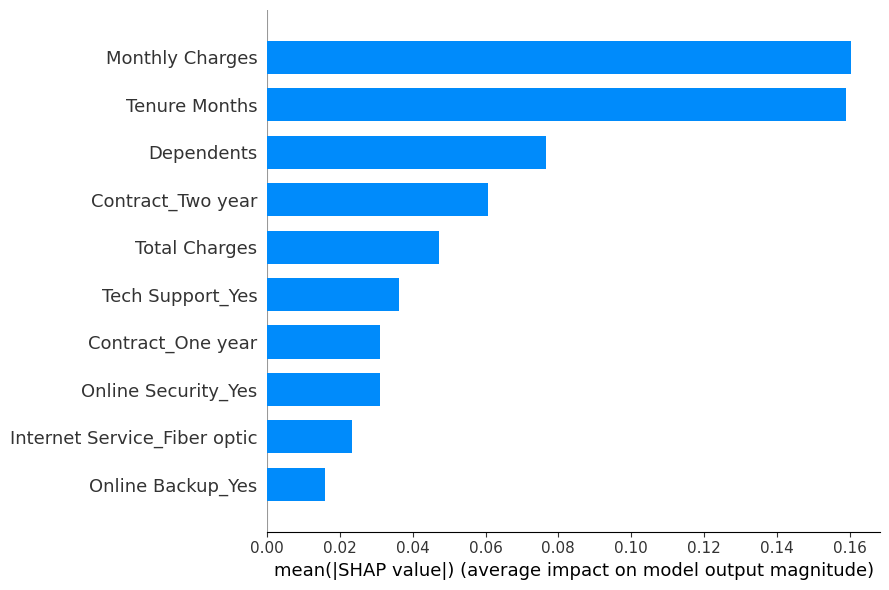

In [15]:
# Valores SHAP
show_shap(log_model, X_train_smote, X_test)

### 3.1.3 Matrix de confusión

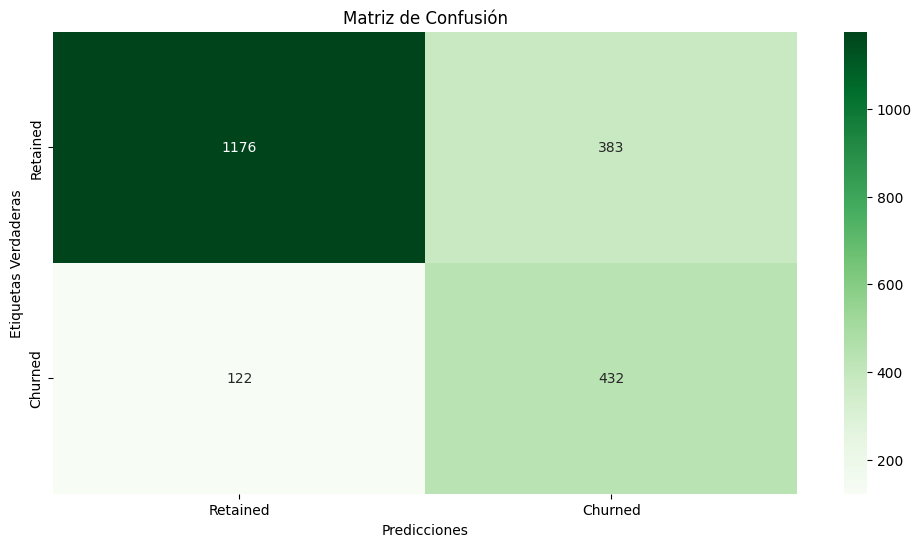

In [16]:
# Matriz de confusión
show_conf_matrix(y_test, y_pred_log)

### 3.1.4 Curva ROC

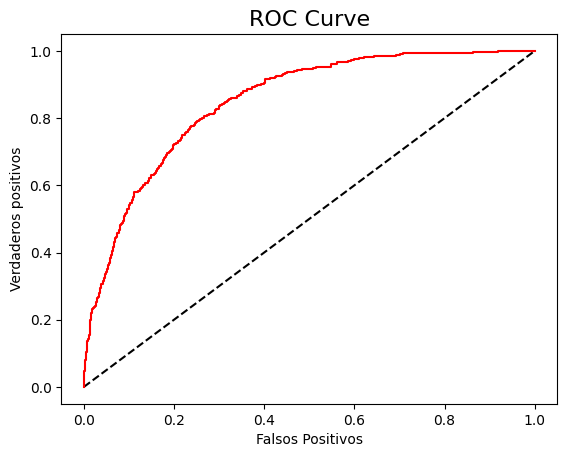

ROC Curve AUC: 0.8482064083474781



In [17]:
# Curva ROC
log_roc = show_roc_curve(log_model, X_test, y_test)

### 3.1.5 Curva Precision-Recall

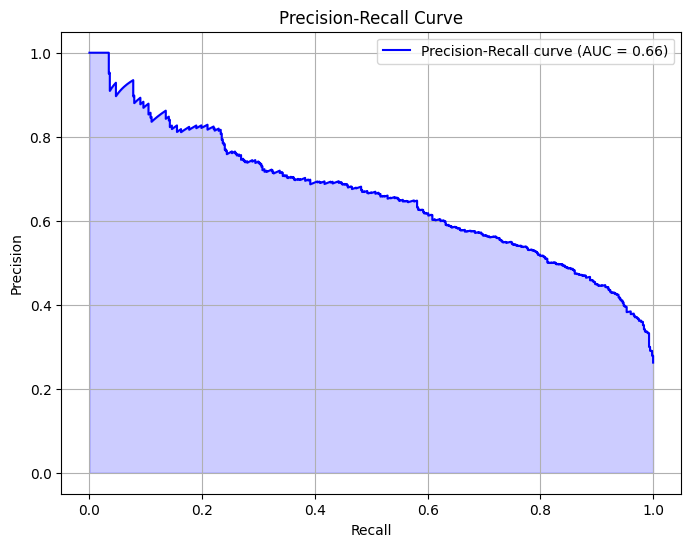

Precision-Recall AUC: 0.6599624458105892


In [18]:
# Curva Precision-Recall
log_pr = show_precision_recall(log_model, X_test, y_test)

### 3.1.6 Conclusiones finales

CONCLUSIONES

## 3.2 Decision Tree

### 3.2.1 Entrenamiento y feature_importance

In [19]:
# Entrenamos el modelo y obtenemos predicciones
y_pred_dt = train_and_features(dt_model, X_train_smote, X_test, y_train_smote, y_test)

Métricas: 
               precision    recall  f1-score   support

           0       0.90      0.74      0.81      1559
           1       0.51      0.77      0.62       554

    accuracy                           0.75      2113
   macro avg       0.71      0.75      0.71      2113
weighted avg       0.80      0.75      0.76      2113

Feature más importantes:
                                    Importance
Contract_Two year                 3.930016e-01
Contract_One year                 2.475753e-01
Dependents                        1.619727e-01
Internet Service_Fiber optic      6.953655e-02
Tenure Months                     6.952022e-02
Monthly Charges                   4.046528e-02
Total Charges                     1.364216e-02
Streaming TV_No internet service  4.286283e-03
Multiple Lines_Yes                3.459622e-15
Paperless Billing                 0.000000e+00


### 3.2.2 SHAP Values


Feature Importance con SHAP


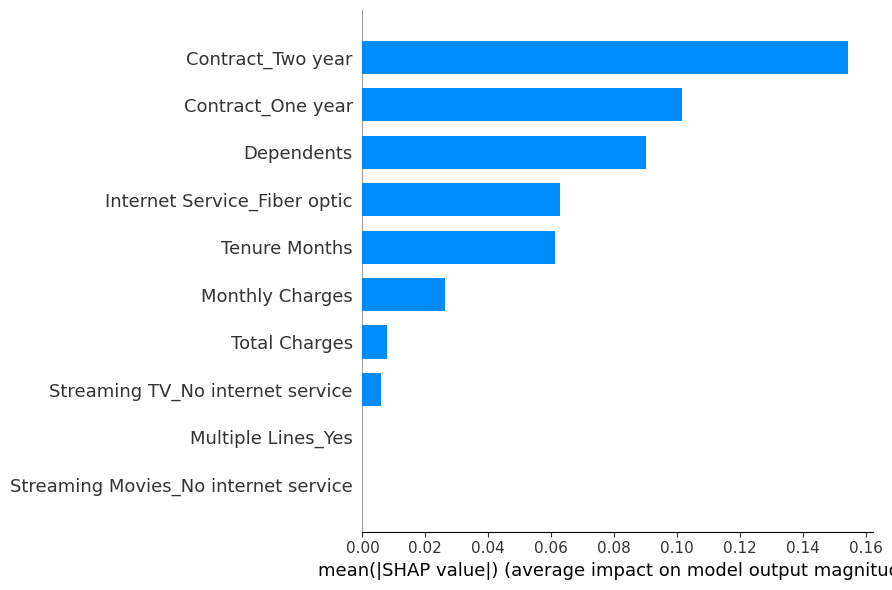

In [20]:
# Valores SHAP
show_shap(dt_model, X_train_smote, X_test)

### 3.2.3 Matriz de confusión

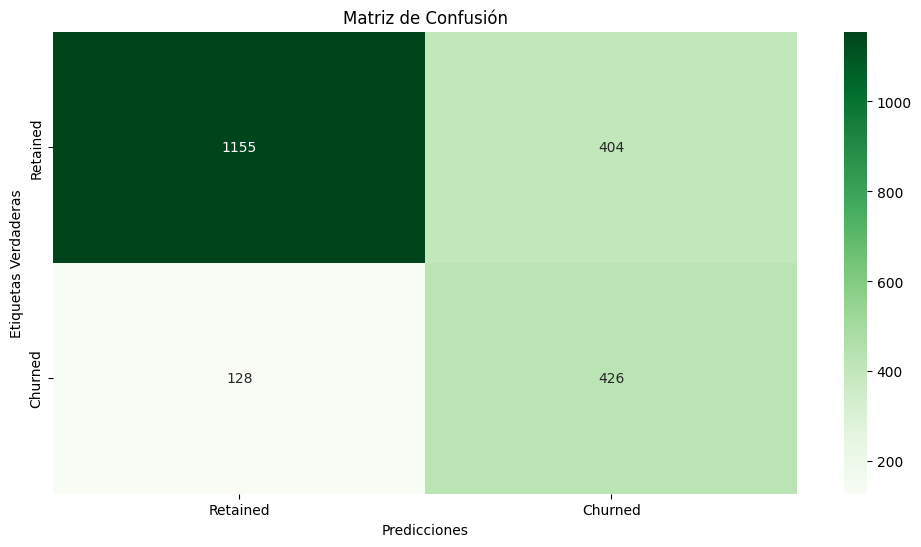

In [21]:
# Matriz de confusión
show_conf_matrix(y_test, y_pred_dt)

### 3.2.4 Curva ROC

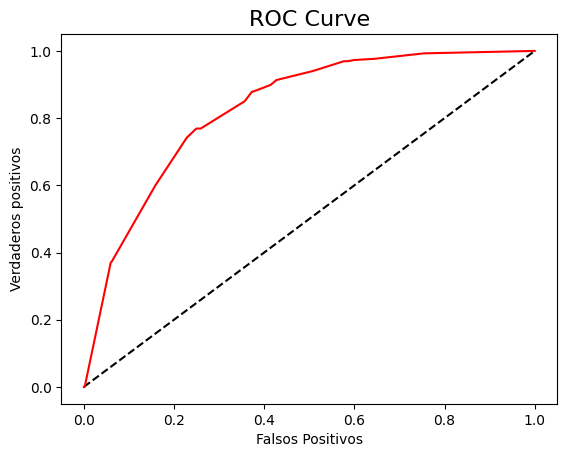

ROC Curve AUC: 0.8295514805149093



In [22]:
# Curva ROC
dt_roc = show_roc_curve(dt_model, X_test, y_test)

### 3.2.5 Curva Precision-Recall

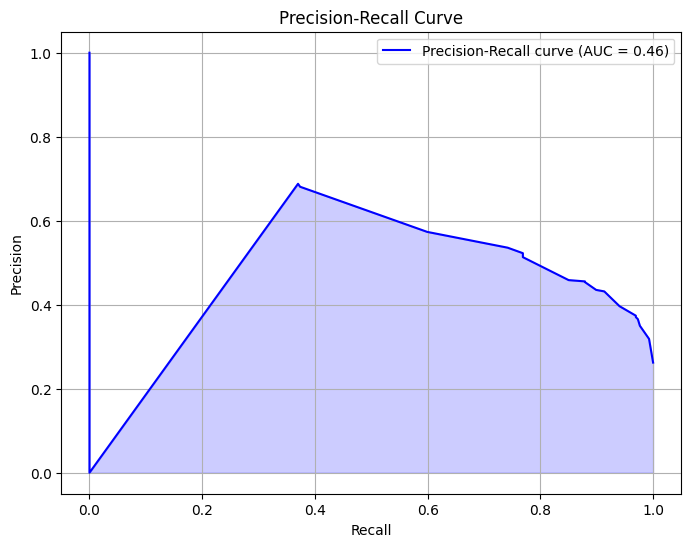

Precision-Recall AUC: 0.46492330950790883


In [23]:
# Curva Precision-Recall
dt_pr = show_precision_recall(dt_model, X_test, y_test)

### 3.2.6 Conclusiones finales

CONCLUSIONES

## 3.3 Random Forest

### 3.3.1 Entrenamiento y feature_importance

In [24]:
# Entrenamos el modelo y obtenemos predicciones
y_pred_rf = train_and_features(rf_model, X_train_smote, X_test, y_train_smote, y_test)

Métricas: 
               precision    recall  f1-score   support

           0       0.87      0.82      0.85      1559
           1       0.57      0.67      0.61       554

    accuracy                           0.78      2113
   macro avg       0.72      0.74      0.73      2113
weighted avg       0.79      0.78      0.79      2113

Feature más importantes:
                                 Importance
Tenure Months                      0.173515
Total Charges                      0.147261
Monthly Charges                    0.122802
Dependents                         0.069917
Contract_Two year                  0.069722
Internet Service_Fiber optic       0.047148
Payment Method_Electronic check    0.038743
Contract_One year                  0.029734
Online Security_Yes                0.028544
Tech Support_Yes                   0.027499


### 3.3.2 SHAP Values


Feature Importance con SHAP


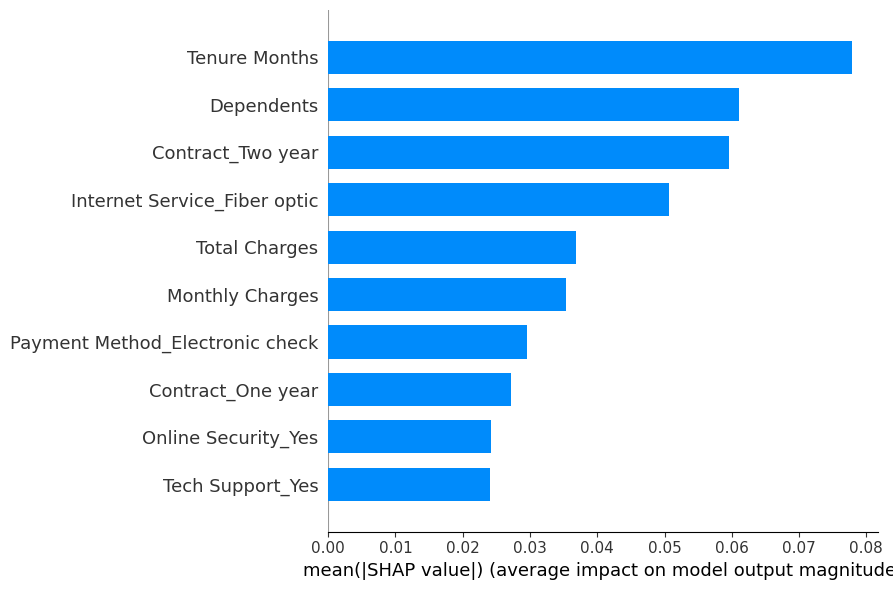

In [25]:
# Valores SHAP
show_shap(rf_model, X_train_smote, X_test)

### 3.3.3 Matriz de confusión

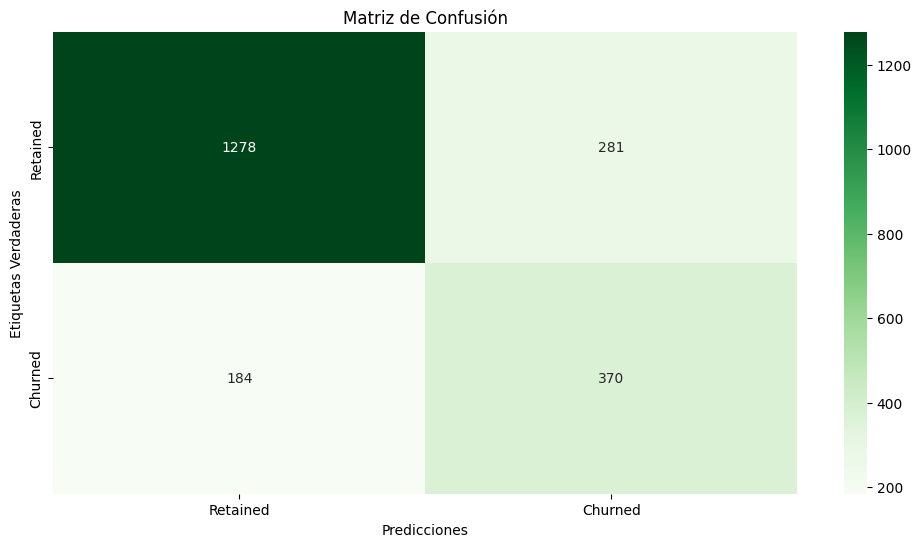

In [26]:
# Matriz de confusión
show_conf_matrix(y_test, y_pred_rf)

3.3.4 Curva ROC

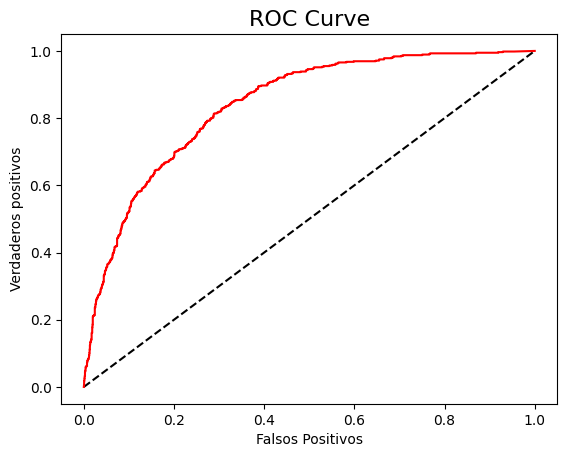

ROC Curve AUC: 0.8392222404901781



In [27]:
# Curva ROC
rf_roc = show_roc_curve(rf_model, X_test, y_test)

### 3.3.5 Curva Precision-Recall

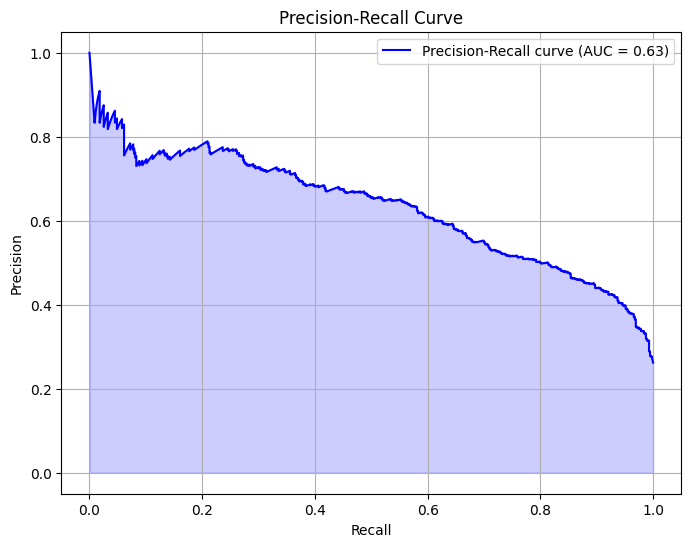

Precision-Recall AUC: 0.6313146003612852


In [28]:
# Curva Precision-Recall
rf_pr = show_precision_recall(rf_model, X_test, y_test)

### 3.3.6 Conclusiones finales

CONCLUSIONES

## 3.4 XGBoost

### 3.4.1 Entrenamiento y feature_importance

In [29]:
# Entrenamos el modelo y obtenemos predicciones
y_pred_xgb = train_and_features(xgb_model, X_train_smote, X_test, y_train_smote, y_test)

Métricas: 
               precision    recall  f1-score   support

           0       0.90      0.76      0.83      1559
           1       0.53      0.77      0.63       554

    accuracy                           0.76      2113
   macro avg       0.72      0.77      0.73      2113
weighted avg       0.81      0.76      0.77      2113

Feature más importantes:
                                     Importance
Contract_Two year                      0.364784
Internet Service_Fiber optic           0.141454
Contract_One year                      0.126912
Dependents                             0.115580
Internet Service_No                    0.035571
Online Security_No internet service    0.026981
Tenure Months                          0.025971
Tech Support_Yes                       0.014014
Streaming Movies_Yes                   0.012662
Paperless Billing                      0.012103


### 3.4.2 SHAP Values


Feature Importance con SHAP


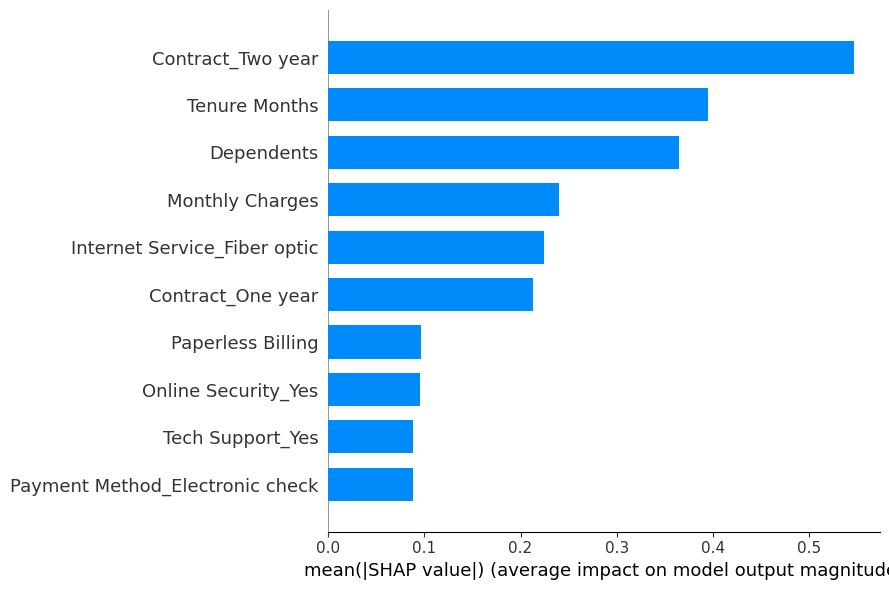

In [30]:
# Valores SHAP
show_shap(xgb_model, X_train_smote, X_test)

### 3.4.3 Matriz de confusión

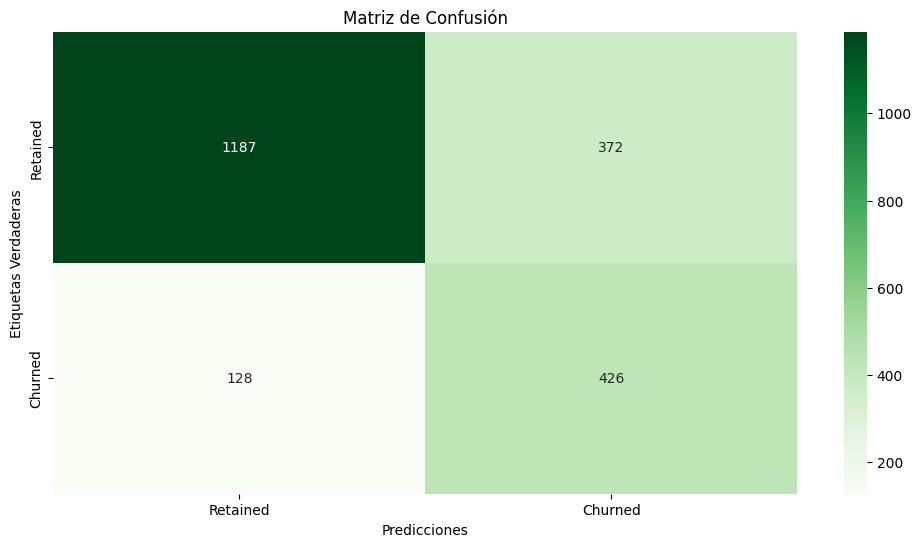

In [31]:
# Matriz de confusión
show_conf_matrix(y_test, y_pred_xgb)

### 3.4.4 Curva ROC

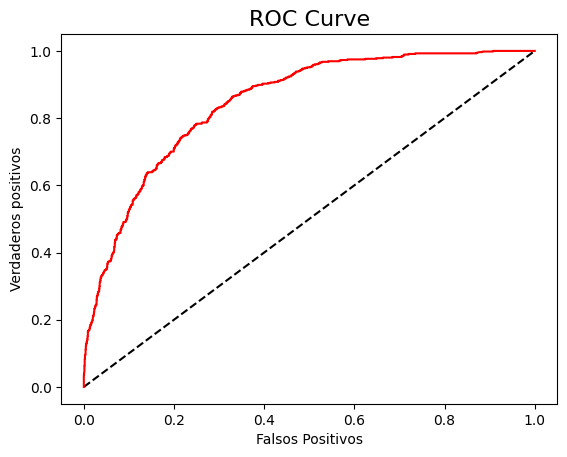

ROC Curve AUC: 0.8470207922786754



In [32]:
# Curva ROC
xgb_roc = show_roc_curve(xgb_model, X_test, y_test)

### 3.4.5 Curva Precision-Recall

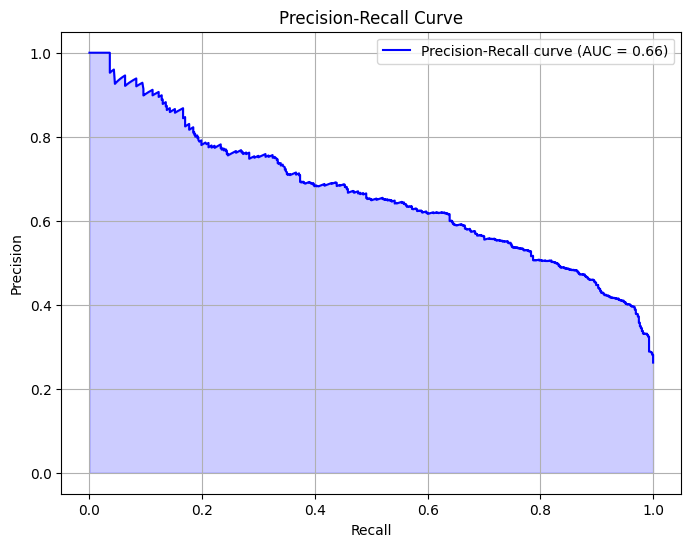

Precision-Recall AUC: 0.662869591912201


In [33]:
# Curva Precision-Recall
xgb_pr = show_precision_recall(xgb_model, X_test, y_test)

### 3.4.6 Conclusiones finales

CONCLUSIONES

## 3.5 LightGBM

### 3.5.1 Entrenamiento y feature_importance

In [34]:
# Entrenamos el modelo y obtenemos predicciones
y_pred_lgbm = train_and_features(lgbm_model, X_train_smote, X_test, y_train_smote, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2169, number of negative: 2711
[LightGBM] [Info] Total Bins 819
[LightGBM] [Info] Number of data points in the train set: 4880, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444467 -> initscore=-0.223051
[LightGBM] [Info] Start training from score -0.223051
Métricas: 
               precision    recall  f1-score   support

           0       0.90      0.77      0.83      1559
           1       0.55      0.76      0.63       554

    accuracy                           0.77      2113
   macro avg       0.72      0.77      0.73      2113
weighted avg       0.81      0.77      0.78      2113

Feature más importantes:
                     Importance
Tenure Months                36
Monthly Charges              34
Dependents                   23
Total Charges                12
Contract_Two year            10
Online Security_Yes          10
Tech

### 3.5.2 SHAP Values

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



Feature Importance con SHAP


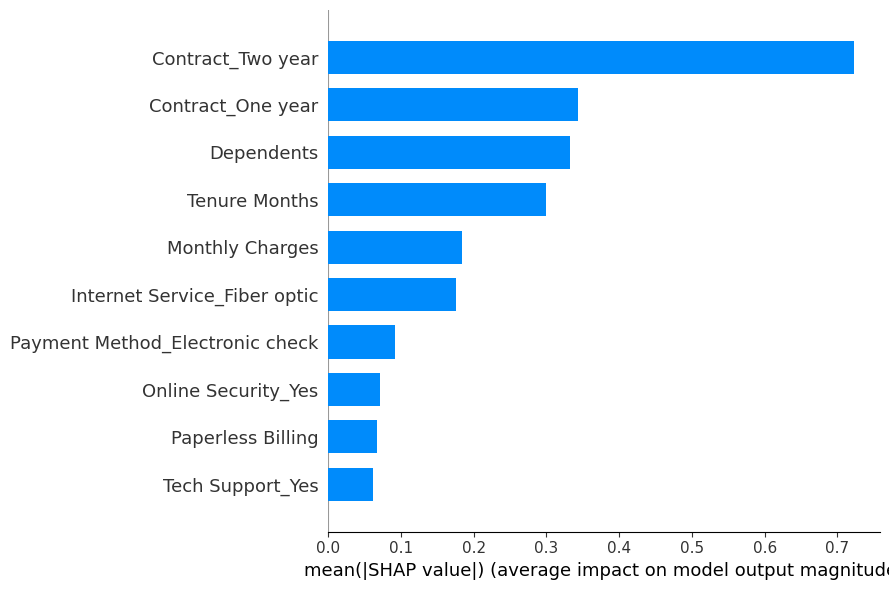

In [35]:
# Valores SHAP
show_shap(lgbm_model, X_train_smote, X_test)

### 3.5.3 Matriz de confusión

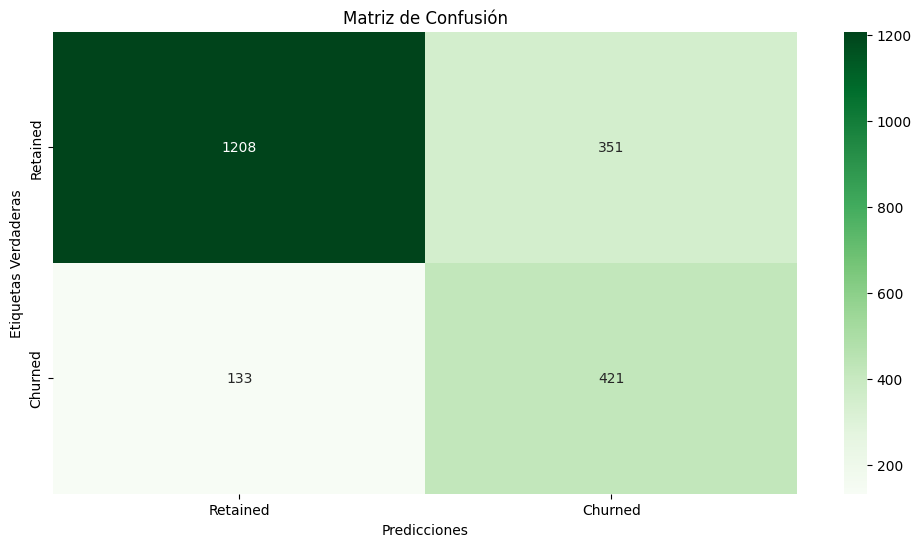

In [36]:
# Matriz de confusión
show_conf_matrix(y_test, y_pred_lgbm)

### 3.5.4 Curva ROC

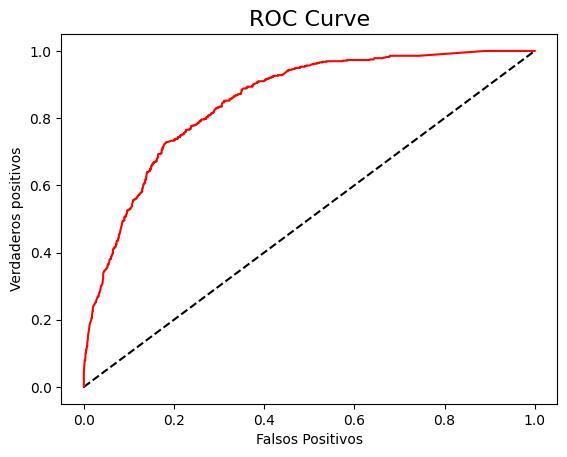

ROC Curve AUC: 0.8509290413414135



In [37]:
# Curva ROC
lgbm_roc = show_roc_curve(lgbm_model, X_test, y_test)

### 3.5.5 Curva Precision-Recall

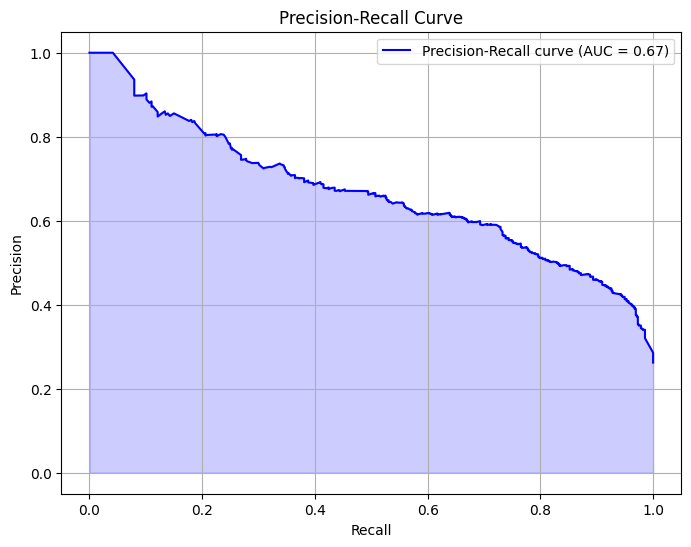

Precision-Recall AUC: 0.6670485079391746


In [38]:
# Curva Precision-Recall
lgbm_pr = show_precision_recall(lgbm_model, X_test, y_test)

### 3.5.6 Conclusiones finales

CONCLUSIONES

## 3.6 Comparativa modelos

In [39]:
# Establecemos los modelos que queremos comparar
predictions = [y_pred_log, y_pred_dt, y_pred_rf, y_pred_xgb, y_pred_lgbm]
models = ['Regresión Logística', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']
auc_roc = [log_roc, dt_roc, rf_roc, xgb_roc, lgbm_roc]
auc_pr = [log_pr, dt_pr, rf_pr, xgb_pr, lgbm_pr]

In [40]:
def get_metrics(y_test, predictions):

  # Estas son las métricas que mostraremos de cada modelo
  metrics = {
        'precision_majority': [], 'precision_minority': [],
        'recall_majority': [], 'recall_minority': [],
        'f1_score': []
    }

  # Obtenemos las métricas para cada modelo
  for pred in predictions:
    metrics['precision_majority'].append(precision_score(y_test, pred, pos_label=0))
    metrics['precision_minority'].append(precision_score(y_test, pred, pos_label=1))
    metrics['recall_majority'].append(recall_score(y_test, pred, pos_label=0))
    metrics['recall_minority'].append(recall_score(y_test, pred, pos_label=1))
    metrics['f1_score'].append(f1_score(y_test, pred, average='weighted'))

  return metrics


In [41]:
# Creamos los gráficos para cada una de las métricas
def show_metrics(metrics, models, auc_roc, auc_pr):

    width = 0.35
    x = np.arange(len(models))
    fig, axes = plt.subplots(2, 3, figsize=(32, 12))

    # Precisión
    bars1 = axes[0, 0].bar(x - width/2, metrics['precision_majority'], width, label='Retained')
    bars2 = axes[0, 0].bar(x + width/2, metrics['precision_minority'], width, label='Churned')
    axes[0, 0].set_title('Precisión')
    axes[0, 0].set_ylabel('Precisión')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(models)
    axes[0, 0].legend()

    # Recall
    bars3 = axes[0, 1].bar(x - width/2, metrics['recall_majority'], width, label='Retained')
    bars4 = axes[0, 1].bar(x + width/2, metrics['recall_minority'], width, label='Churned')
    axes[0, 1].set_title('Recall')
    axes[0, 1].set_ylabel('Recall')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(models)
    axes[0, 1].legend()

    # F1-Score
    bars5 = axes[0, 2].bar(models, metrics['f1_score'])
    axes[0, 2].set_title('F1-Score ponderado')
    axes[0, 2].set_ylabel('F1-Score')

    # AUC ROC
    bars6 = axes[1, 0].bar(models, auc_roc, color='orange')
    axes[1, 0].set_title('AUC ROC')
    axes[1, 0].set_ylabel('AUC ROC')

    # AUC Precision-Recall
    bars7 = axes[1, 1].bar(models, auc_pr, color='green')
    axes[1, 1].set_title('AUC Precision-Recall')
    axes[1, 1].set_ylabel('AUC Precision-Recall')

    plt.tight_layout()
    plt.show()

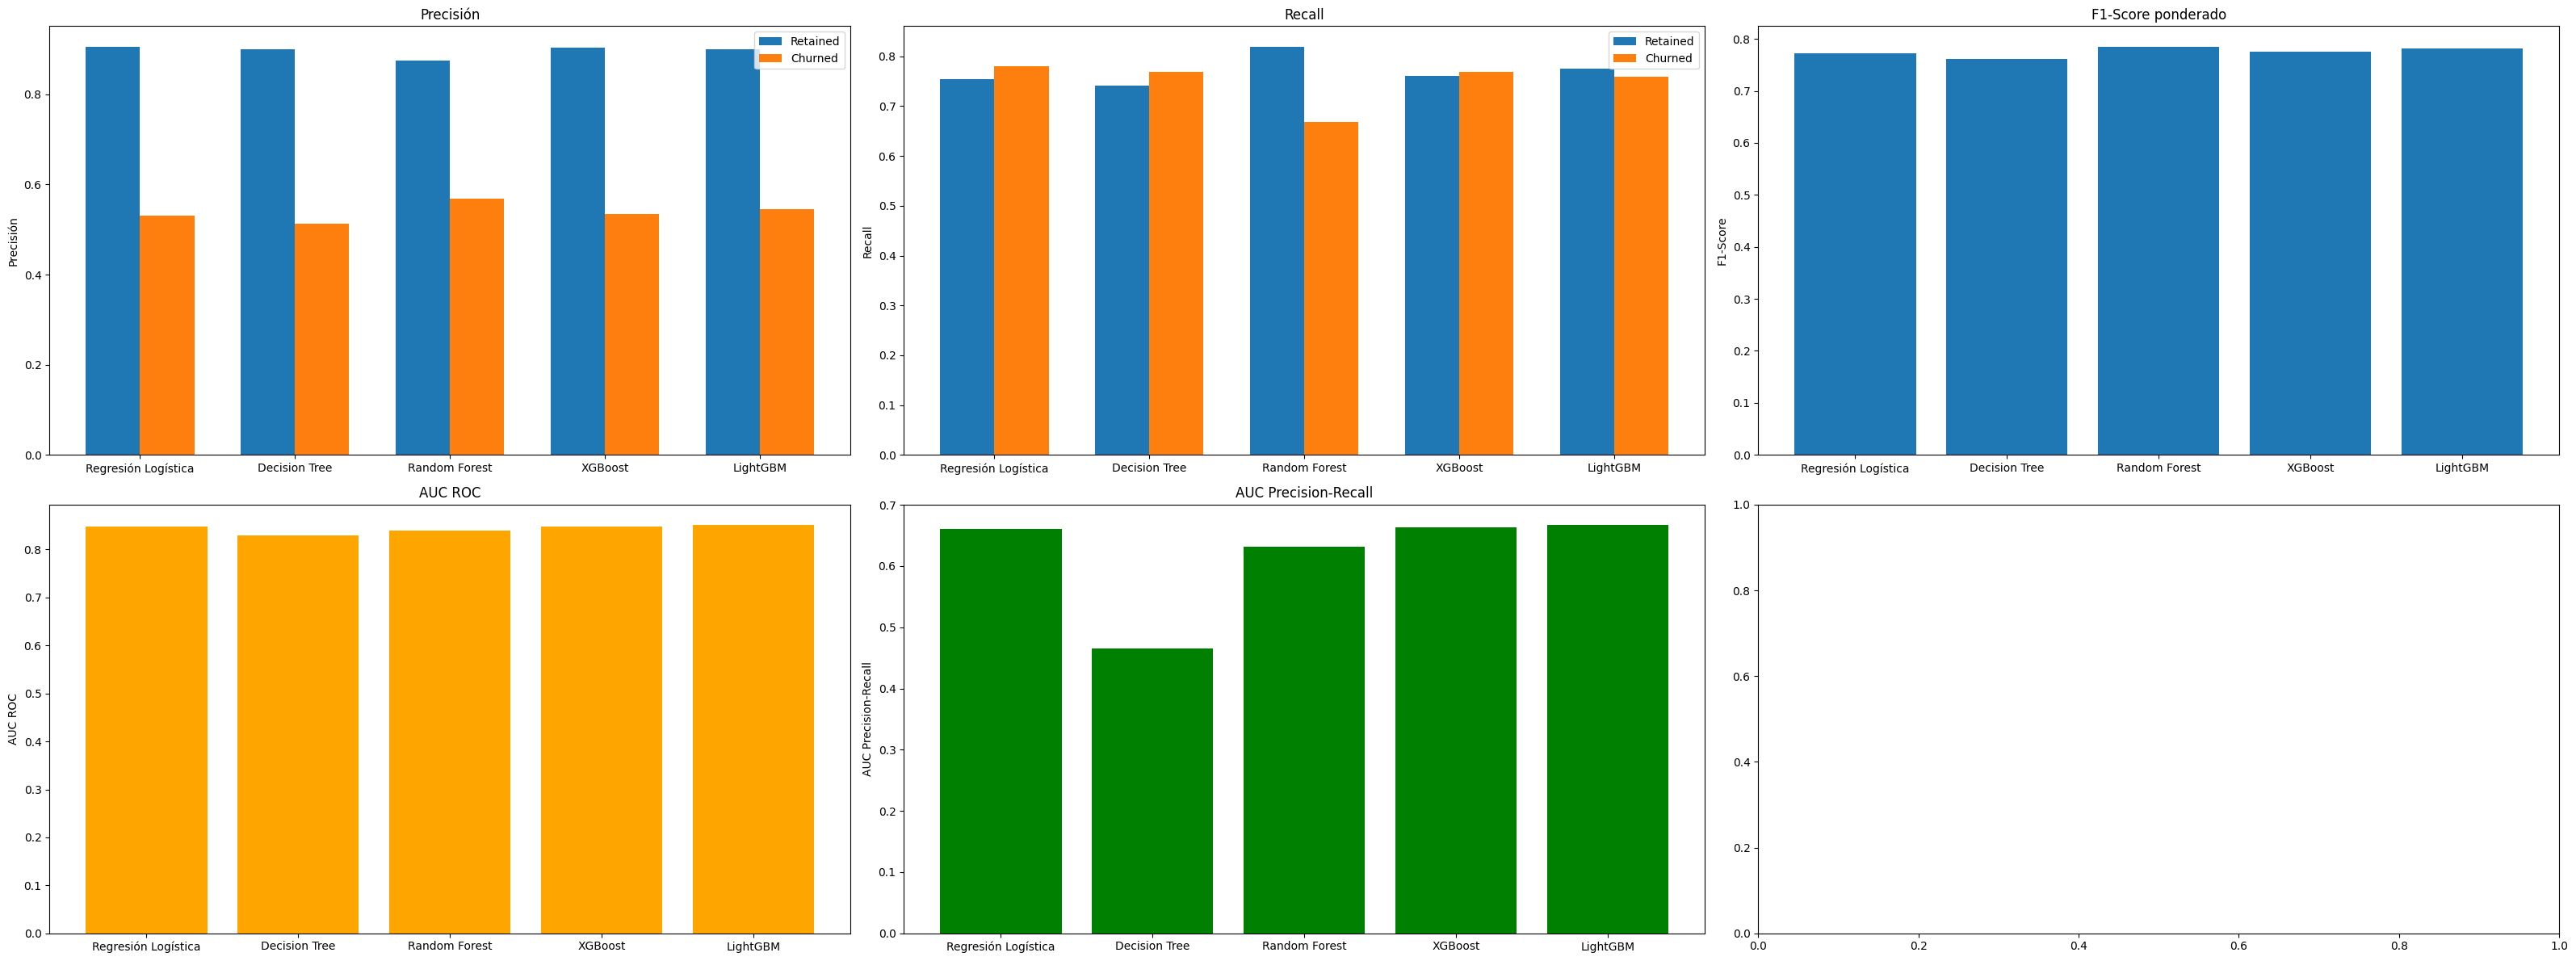

In [42]:
metrics = get_metrics(y_test, predictions)
show_metrics(metrics, models, auc_roc, auc_pr)

CONCLUSIONES FINALES

# 4 Fine-Tuning

Una vez hemos probado diferentes modelos, y viendo que XGBoost es el que más conviene en general, aplicamos GridSearch sobre este modelo para buscar los mejores hiperparámetros que nos permitan mejorar el rendimiento de este modelo.

## 4.1 GridSearchCV

In [43]:
# GridSearchCV
xgb_model_tune = XGBClassifier(force_col_wise=True)

pipeline_xgb = Pipeline([
    ('smote', SMOTE()),
    ('under', RandomUnderSampler()),
    ('xgb', xgb_model_tune)
])

# Definimos la lista de valores para optimizar el modelo
param_grid = {
    'smote__sampling_strategy': [0.5, 0.55, 0.6],
    'under__sampling_strategy': [0.7, 0.72, 0.8],
    'xgb__n_estimators':[15, 25, 35],
    'xgb__learning_rate': [0.02, 0.05, 0.1],
    'xgb__max_depth':[5, 7, 10],
    'xgb__scale_pos_weight':[1,1.1, 1.12],
    'xgb__min_child_weight':[0, 1, 2],
    'xgb__colsample_bytree':[0.5, 0.6, 0.7]
}

# Configurar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Configurar GridSearchCV con el pipeline
grid_search_xgb = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid,
    cv=cv,
    scoring='average_precision',
    refit='recall',
    n_jobs=-1,
    verbose=2
)

### 4.1.1 Entrenamiento

In [44]:
# Entrenamos el modelo y obtenemos predicciones
grid_search_xgb.fit(X_train, y_train)

# Resultados
print('Mejores parámetros: ', grid_search_xgb.best_params_)

y_pred_xgb_t = grid_search_xgb.best_estimator_.predict(X_test)
print(f'Métricas: \n {classification_report(y_test,y_pred_xgb_t)}')

print('Mejores parámetros: ', grid_search_xgb.best_params_)

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
Mejores parámetros:  {'smote__sampling_strategy': 0.5, 'under__sampling_strategy': 0.7, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 35, 'xgb__scale_pos_weight': 1}
Métricas: 
               precision    recall  f1-score   support

           0       0.89      0.82      0.85      1559
           1       0.58      0.71      0.64       554

    accuracy                           0.79      2113
   macro avg       0.73      0.76      0.74      2113
weighted avg       0.81      0.79      0.79      2113

Mejores parámetros:  {'smote__sampling_strategy': 0.5, 'under__sampling_strategy': 0.7, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 35, 'xgb__scale_pos_weight': 1}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:58:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "force_col_wise" } are not used.

  warnings.warn(smsg, UserWarning)


### 4.1.2 Matriz de confusión

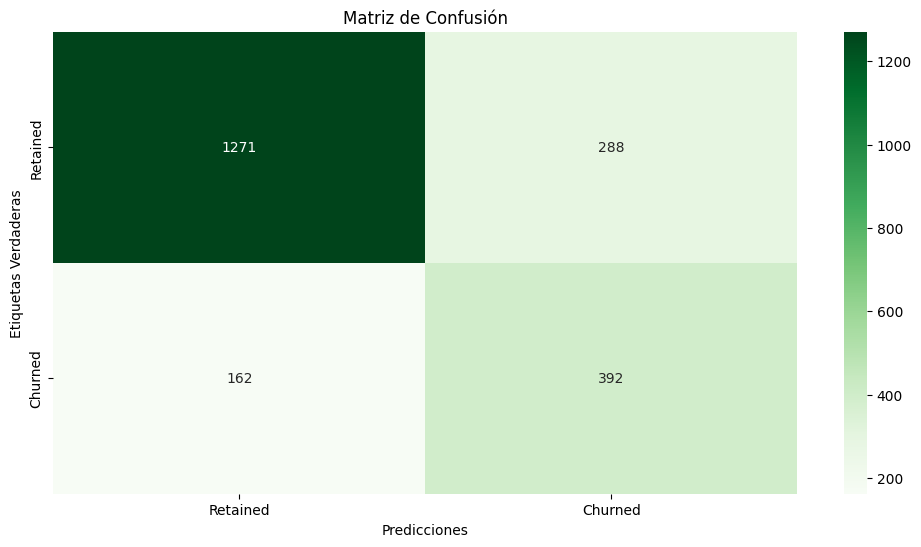

In [45]:
# Matriz de confusión
show_conf_matrix(y_test, y_pred_xgb_t)

### 4.1.3 Curva ROC

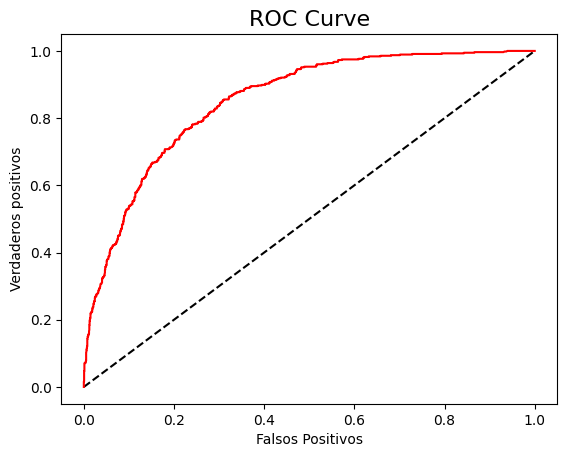

ROC Curve AUC: 0.8511663961208126



In [46]:
# Curva ROC
xgb_roc_t = show_roc_curve(grid_search_xgb, X_test, y_test)

### 4.1.4 Curva Precision-Recall

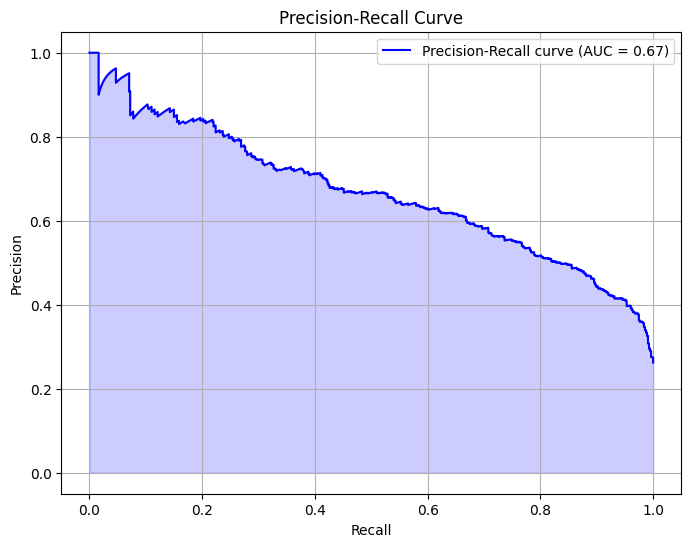

Precision-Recall AUC: 0.6667882523782089


In [47]:
# Curva Precision-Recall
xgb_pr_t = show_precision_recall(grid_search_xgb, X_test, y_test)

### 4.1.5 Conclusiones finales

CONCLUSIONES

### 4.2 Comparativa final

In [48]:
# Establecemos los modelos que queremos comparar
predictions_t = [y_pred_xgb, y_pred_xgb_t]
models_t = ['XGBoost', 'XGBoost + GridSearch']
auc_roc_t = [xgb_roc, xgb_roc_t]
auc_pr_t = [xgb_pr, xgb_pr_t]

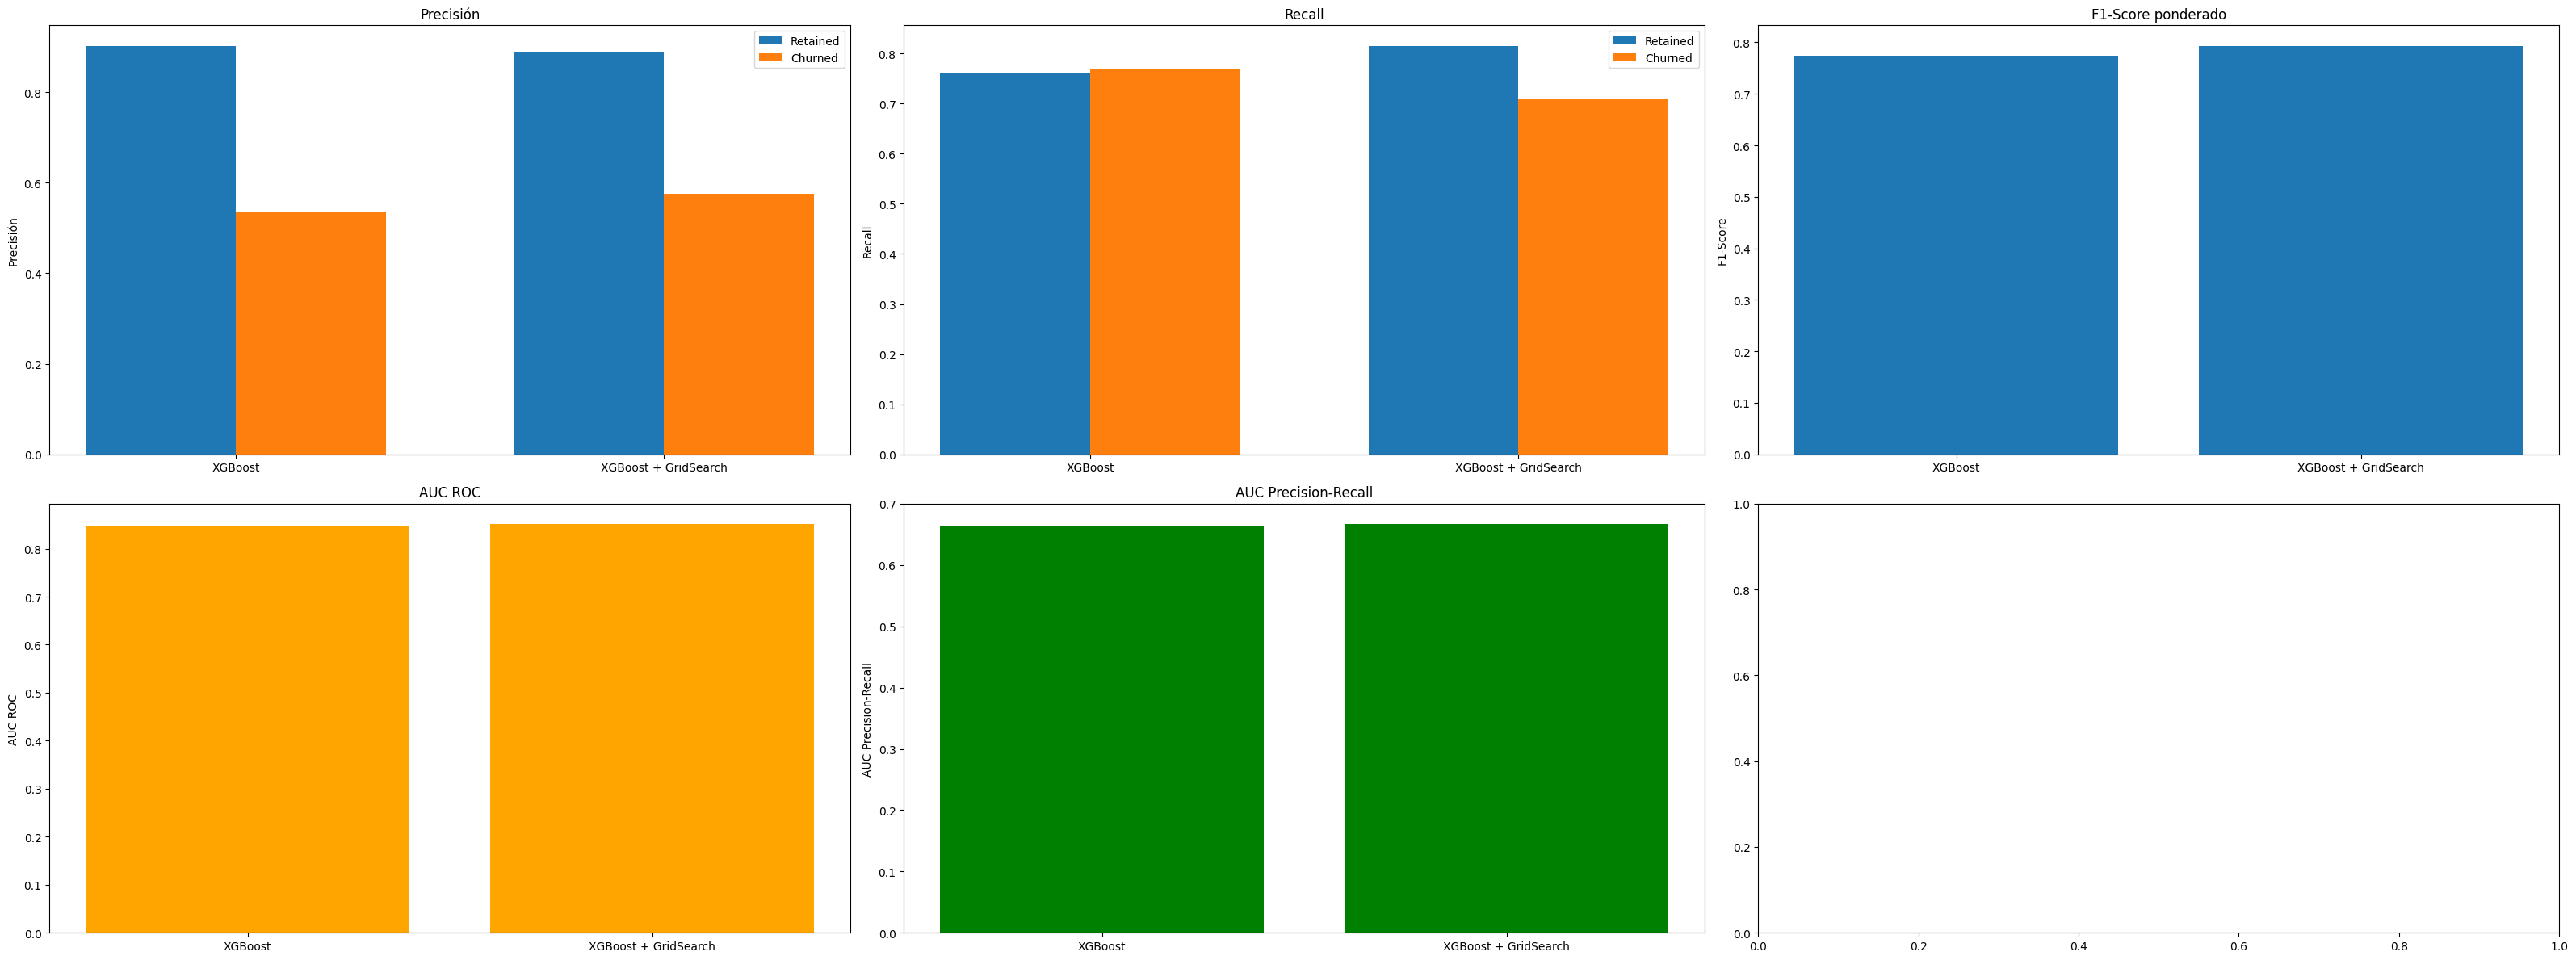

In [49]:
metrics_t = get_metrics(y_test, predictions_t)
show_metrics(metrics_t, models_t, auc_roc_t, auc_pr_t)

CONCLUSIONES FINALES

# 5. Exportación del mejor modelo

In [53]:
dump(grid_search_xgb, 'best_model.joblib')

['best_model.joblib']

In [54]:
print(grid_search_xgb)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('under', RandomUnderSampler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_me...
            

In [55]:
from google.colab import files

# Ruta del modelo guardado
files.download('best_model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>